In [1]:
!pip install statsmodels

In [2]:
# ==============================
# 1. Setup & Imports
# ==============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# For time-series demand forecasting (optional)
from statsmodels.tsa.arima.model import ARIMA
#from prophet import Prophet  # if available

# Ignore warnings for readability
import warnings
warnings.filterwarnings('ignore')


In [3]:
# ==============================
# 2. Data Loading & Preparation
# ==============================

# Load your dataset (replace with your path)
airline_df = pd.read_csv("airline_data.csv")   # Kaggle dataset
rideshare_df = pd.read_csv("rideshare_data.csv")  # Optional second dataset

# Quick overview
print(airline_df.head())
print(airline_df.info())
print(airline_df.describe())

# Handle missing values
airline_df = airline_df.dropna()

# Construct a pseudo-date using Year + Quarter (first day of quarter)
airline_df['quarter_start_month'] = (airline_df['quarter'] - 1) * 3 + 1
airline_df['date'] = pd.to_datetime(dict(
    year=airline_df['Year'],
    month=airline_df['quarter_start_month'],
    day=1
))

# Extract temporal features
airline_df['month'] = airline_df['date'].dt.month
airline_df['year'] = airline_df['date'].dt.year
airline_df['quarter'] = airline_df['date'].dt.quarter


# Example: demand proxy (bookings per quarter)
daily_demand = airline_df.groupby('date')['passengers'].sum().reset_index()
daily_demand.columns = ['date', 'demand']


       tbl  Year  quarter  citymarketid_1  citymarketid_2  \
0  Table1a  2021        3           30135           33195   
1  Table1a  2021        3           30135           33195   
2  Table1a  2021        3           30140           30194   
3  Table1a  2021        3           30140           30194   
4  Table1a  2021        3           30140           30466   

                            city1                          city2  airportid_1  \
0  Allentown/Bethlehem/Easton, PA  Tampa, FL (Metropolitan Area)        10135   
1  Allentown/Bethlehem/Easton, PA  Tampa, FL (Metropolitan Area)        10135   
2                 Albuquerque, NM          Dallas/Fort Worth, TX        10140   
3                 Albuquerque, NM          Dallas/Fort Worth, TX        10140   
4                 Albuquerque, NM                    Phoenix, AZ        10140   

   airportid_2 airport_1  ...    fare  carrier_lg  large_ms  fare_lg  \
0        14112       ABE  ...   81.43          G4    1.0000    81.43   
1 

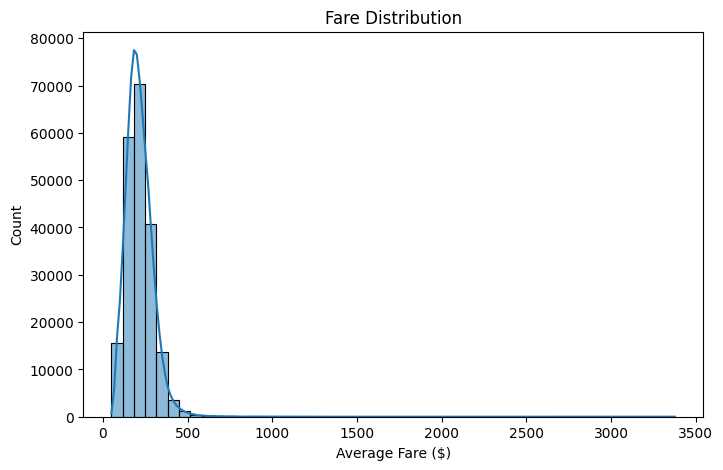

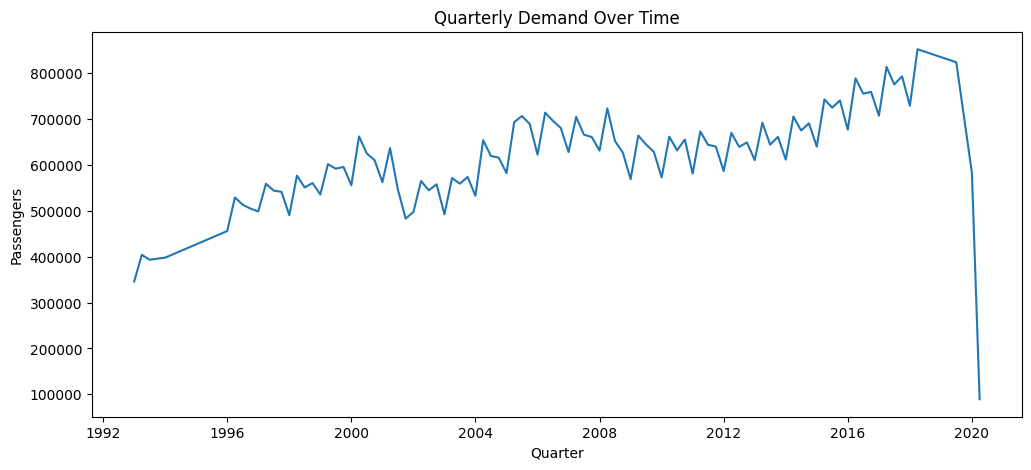

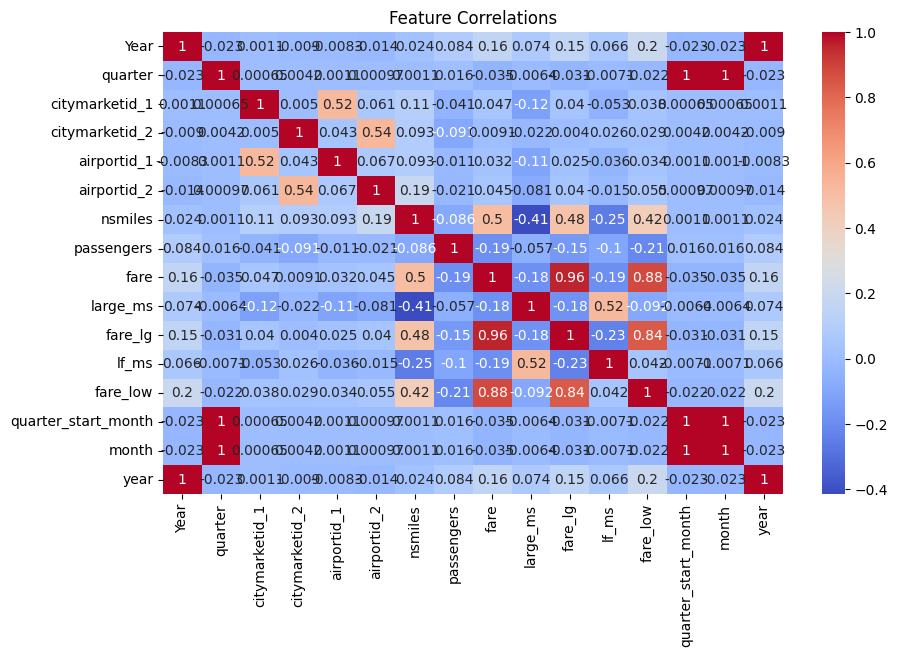

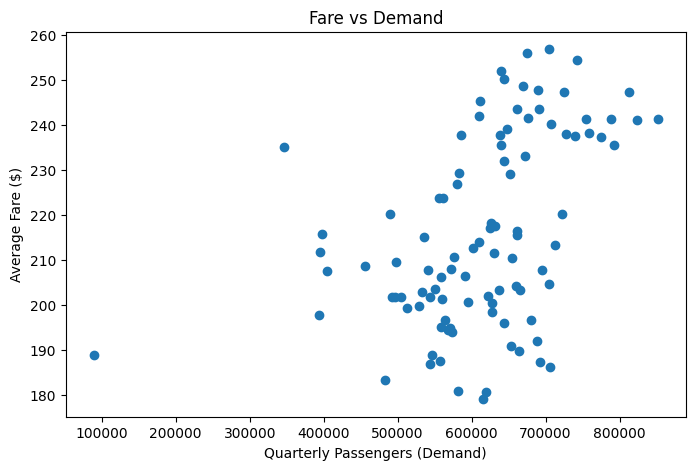

In [4]:
# ==============================
# 3. Exploratory Data Analysis (EDA)
# ==============================

# Use "fare" instead of "price"
plt.figure(figsize=(8,5))
sns.histplot(airline_df['fare'], bins=50, kde=True)
plt.title("Fare Distribution")
plt.xlabel("Average Fare ($)")
plt.show()

# Construct a pseudo-date using Year + Quarter
airline_df['period'] = pd.PeriodIndex(year=airline_df['Year'], 
                                      quarter=airline_df['quarter'], 
                                      freq='Q').to_timestamp()

# Aggregate demand (passengers per quarter)
quarterly_demand = airline_df.groupby('period')['passengers'].sum().reset_index()

# Demand over time
plt.figure(figsize=(12,5))
plt.plot(quarterly_demand['period'], quarterly_demand['passengers'])
plt.title("Quarterly Demand Over Time")
plt.xlabel("Quarter")
plt.ylabel("Passengers")
plt.show()

# Correlation matrix (numeric features only)
plt.figure(figsize=(10,6))
sns.heatmap(airline_df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Feature Correlations")
plt.show()

# Fare vs Demand scatter (quarterly average fare vs passengers)
quarterly_fare = airline_df.groupby('period')['fare'].mean().reset_index()
merged = pd.merge(quarterly_demand, quarterly_fare, on='period')

plt.figure(figsize=(8,5))
plt.scatter(merged['passengers'], merged['fare'])
plt.xlabel("Quarterly Passengers (Demand)")
plt.ylabel("Average Fare ($)")
plt.title("Fare vs Demand")
plt.show()


In [5]:
# ==============================
# 4. Baseline Models
# ==============================

# Use "fare" as the target instead of "price"
y = airline_df['fare']

# Features: distance (nsmiles), passengers, Year, quarter
features = ['nsmiles', 'passengers', 'Year', 'quarter']
X = airline_df[features]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ---- Linear Regression ----
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_test)

print("Linear Regression RMSE:", np.sqrt(mean_squared_error(y_test, lr_preds)))
print("Linear Regression R2:", r2_score(y_test, lr_preds))

# ---- Random Forest ----
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test, rf_preds)))
print("Random Forest R2:", r2_score(y_test, rf_preds))


Linear Regression RMSE: 68.39019940732473
Linear Regression R2: 0.291967838148419
Random Forest RMSE: 51.35277621018752
Random Forest R2: 0.6007976400687822


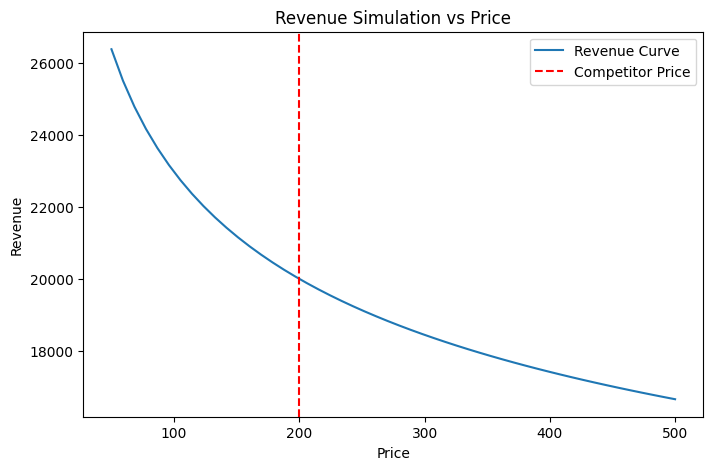

In [6]:
# ==============================
# 5. Revenue Simulation
# ==============================

def calculate_revenue(price, base_demand, price_elasticity=-1.0, competitor_price=100):
    """
    Simple revenue calculation with price elasticity.
    """
    demand_adjustment = (price / competitor_price) ** price_elasticity
    adjusted_demand = base_demand * demand_adjustment
    revenue = price * adjusted_demand
    return revenue

# Simulate revenue for different price points
price_range = np.linspace(50, 500, 50)  # Adjust according to dataset
base_demand = 100  # assume 100 customers baseline
competitor_price = 200

revenues = [calculate_revenue(p, base_demand, -1.2, competitor_price) for p in price_range]

plt.figure(figsize=(8,5))
plt.plot(price_range, revenues, label="Revenue Curve")
plt.axvline(x=competitor_price, color="red", linestyle="--", label="Competitor Price")
plt.title("Revenue Simulation vs Price")
plt.xlabel("Price")
plt.ylabel("Revenue")
plt.legend()
plt.show()


In [7]:
# Encode categorical features
cat_features = ['carrier_lg', 'city1', 'city2']
airline_encoded = pd.get_dummies(airline_df[cat_features], drop_first=True)

# Combine numeric + encoded features
num_features = airline_df[['nsmiles', 'passengers', 'Year', 'quarter', 'fare_low', 'fare_lg', 'large_ms', 'lf_ms']]
X = pd.concat([num_features, airline_encoded], axis=1)
y = airline_df['fare']


In [8]:
# ==========================================
# 1. Setup & Imports
# ==========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from xgboost import XGBRegressor, plot_importance

import warnings
warnings.filterwarnings('ignore')

# Set seed for reproducibility
RANDOM_STATE = 42


In [9]:
# ==========================================
# 2. Load & Inspect Dataset
# ==========================================
# Replace with your dataset path
df = pd.read_csv("airline_data.csv")

print(df.head())
print(df.info())


       tbl  Year  quarter  citymarketid_1  citymarketid_2  \
0  Table1a  2021        3           30135           33195   
1  Table1a  2021        3           30135           33195   
2  Table1a  2021        3           30140           30194   
3  Table1a  2021        3           30140           30194   
4  Table1a  2021        3           30140           30466   

                            city1                          city2  airportid_1  \
0  Allentown/Bethlehem/Easton, PA  Tampa, FL (Metropolitan Area)        10135   
1  Allentown/Bethlehem/Easton, PA  Tampa, FL (Metropolitan Area)        10135   
2                 Albuquerque, NM          Dallas/Fort Worth, TX        10140   
3                 Albuquerque, NM          Dallas/Fort Worth, TX        10140   
4                 Albuquerque, NM                    Phoenix, AZ        10140   

   airportid_2 airport_1  ...    fare  carrier_lg  large_ms  fare_lg  \
0        14112       ABE  ...   81.43          G4    1.0000    81.43   
1 

In [10]:
# ==========================================
# 3. Feature Engineering
# ==========================================
df['route'] = df['city1'] + "_" + df['city2']   # route combination
df['year_quarter'] = df['Year'].astype(str) + "Q" + df['quarter'].astype(str)

# Distance buckets
df['distance_bucket'] = pd.cut(df['nsmiles'], 
                               bins=[0, 500, 1000, 1500, 2000, 3000], 
                               labels=["0-500", "500-1k", "1k-1.5k", "1.5k-2k", "2k-3k"])

# Seasonality
df['is_peak'] = df['quarter'].apply(lambda x: 1 if x in [2,3] else 0)

# Market concentration feature
df['market_share_diff'] = abs(df['large_ms'] - df['lf_ms'])


In [11]:
# ==========================================
# 4. Define Features & Target
# ==========================================
target = "fare"
features = ['nsmiles', 'passengers', 'large_ms', 'fare_lg',
            'lf_ms', 'fare_low', 'distance_bucket', 'is_peak',
            'carrier_lg', 'carrier_low', 'route']

X = df[features]
y = df[target]


In [12]:
# ==========================================
# 5. Preprocessing (One-Hot Encoding for Categorical)
# ==========================================
categorical_cols = ['distance_bucket', 'carrier_lg', 'carrier_low', 'route']
numerical_cols = [col for col in features if col not in categorical_cols]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])


In [13]:
# ==========================================
# 6. Train/Test Split
# ==========================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE)


In [14]:
# ==========================================
# 7. XGBoost Model + Pipeline
# ==========================================
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_STATE
)

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', xgb_model)])

pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['nsmiles', 'passengers',
                                                   'large_ms', 'fare_lg',
                                                   'lf_ms', 'fare_low',
                                                   'is_peak']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['distance_bucket',
                                                   'carrier_lg', 'carrier_low',
                                                   'route'])])),
                ('model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=...
                              feature_types=None, feature_weights=None,
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=6, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=300, n_jobs=None,
                              num_parallel_tree=None, ...))])

In [15]:
# ==========================================
# 8. Evaluation
# ==========================================
y_pred = pipeline.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("XGBoost RMSE:", rmse)
print("XGBoost R2:", r2)


XGBoost RMSE: 26.33705481244808
XGBoost R2: 0.8951750454094639


<Figure size 1200x600 with 0 Axes>

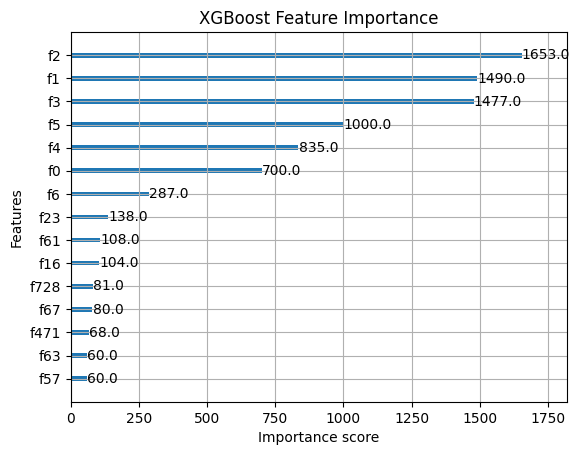

In [16]:
# ==========================================
# 9. Feature Importance
# ==========================================
xgb_model.fit(preprocessor.fit_transform(X_train), y_train)

plt.figure(figsize=(12, 6))
plot_importance(xgb_model, max_num_features=15, importance_type='weight')
plt.title("XGBoost Feature Importance")
plt.show()


In [17]:
# Define the feature set you want to use for training
feature_cols = [
    'nsmiles',          # distance between airports
    'passengers',       # demand proxy
    'quarter',          # seasonality
    'Year',             # temporal trend
    'large_ms',         # market share of largest carrier
    'lf_ms'             # market share of lowest fare carrier
    # add more if you engineered them earlier
]

# Build feature matrix and target
X = airline_df[feature_cols]
y = airline_df['fare']


In [18]:
# ==============================
# 5. Model Robustness Checks
# ==============================

from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBRegressor

# Reuse your enriched features
X = airline_df[feature_cols]
y = airline_df['fare']

# -----------------------------
# (A) K-Fold Cross Validation
# -----------------------------
print("=== K-Fold Cross Validation (5 folds) ===")

xgb_model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

cv_rmse = -cross_val_score(
    xgb_model, X, y,
    scoring="neg_root_mean_squared_error",
    cv=kf
)

print("Fold RMSEs:", cv_rmse)
print("Mean RMSE:", cv_rmse.mean())
print("Std Dev:", cv_rmse.std())


# -----------------------------
# (B) Temporal Validation
# -----------------------------
print("\n=== Temporal Validation ===")

# Example: train on <2018, test on >=2018
train_df = airline_df[airline_df['Year'] < 2018]
test_df  = airline_df[airline_df['Year'] >= 2018]

X_train = train_df[feature_cols]
y_train = train_df['fare']
X_test  = test_df[feature_cols]
y_test  = test_df['fare']

xgb_model.fit(X_train, y_train)
temporal_preds = xgb_model.predict(X_test)

rmse_temporal = np.sqrt(mean_squared_error(y_test, temporal_preds))
r2_temporal = r2_score(y_test, temporal_preds)

print("Temporal RMSE:", rmse_temporal)
print("Temporal R2:", r2_temporal)


=== K-Fold Cross Validation (5 folds) ===
Fold RMSEs: [51.94502283 49.69941176 49.21321152 49.50251537 48.80096648]
Mean RMSE: 49.83222559088584
Std Dev: 1.0988115662415578

=== Temporal Validation ===
Temporal RMSE: 57.22801749134981
Temporal R2: 0.334460067891279


In [19]:
# ==============================
# Step 1: Temporal Feature Engineering
# ==============================

# Encode cyclic time features
airline_df['month'] = ((airline_df['quarter'] - 1) * 3 + 1)  # approx month from quarter
airline_df['month_sin'] = np.sin(2 * np.pi * airline_df['month'] / 12)
airline_df['month_cos'] = np.cos(2 * np.pi * airline_df['month'] / 12)

airline_df['quarter_sin'] = np.sin(2 * np.pi * airline_df['quarter'] / 4)
airline_df['quarter_cos'] = np.cos(2 * np.pi * airline_df['quarter'] / 4)

# Lag feature: mean fare per route (last year)
airline_df = airline_df.sort_values(['citymarketid_1','citymarketid_2','Year','quarter'])
airline_df['fare_lag1y'] = airline_df.groupby(['citymarketid_1','citymarketid_2'])['fare'].shift(4)

# Rolling demand trend: avg passengers past 4 quarters
airline_df['passengers_roll4'] = airline_df.groupby(['citymarketid_1','citymarketid_2'])['passengers'].shift().rolling(4).mean()

# Drop NA introduced by lagging
airline_df = airline_df.dropna()


In [20]:
# Updated feature set
feature_cols = [
    'nsmiles', 'passengers', 'large_ms', 'lf_ms',
    'month_sin','month_cos','quarter_sin','quarter_cos',
    'fare_lag1y','passengers_roll4'
]

X = airline_df[feature_cols]
y = airline_df['fare']

from xgboost import XGBRegressor

xgb_model = XGBRegressor(
    n_estimators=800,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Train/Test split temporally
train_df = airline_df[airline_df['Year'] < 2018]
test_df  = airline_df[airline_df['Year'] >= 2018]

X_train, y_train = train_df[feature_cols], train_df['fare']
X_test, y_test   = test_df[feature_cols], test_df['fare']

xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

print("Temporal RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("Temporal R2:", r2_score(y_test, y_pred))


Temporal RMSE: 49.67088803339102
Temporal R2: 0.4958748552992722


<Figure size 1000x600 with 0 Axes>

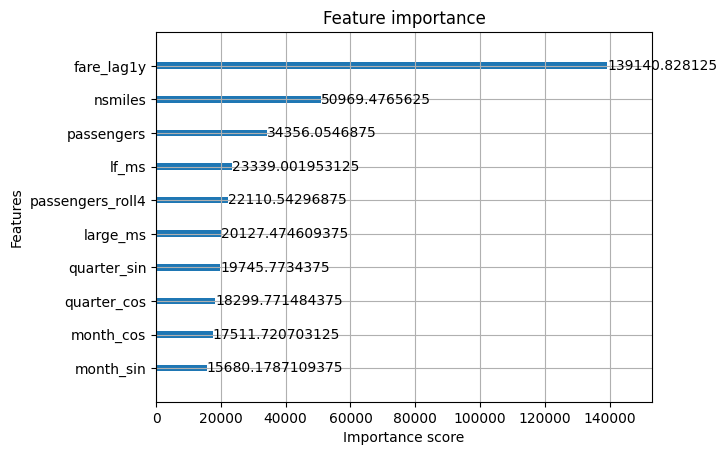

In [21]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

plt.figure(figsize=(10,6))
plot_importance(xgb_model, importance_type='gain', max_num_features=10)
plt.show()


In [22]:
# ==============================
# Step 0: Train Demand Model
# ==============================

from xgboost import XGBRegressor

# Features = your enriched features + 'fare'
X_demand = airline_df[feature_cols + ['fare']]
y_demand = airline_df['passengers']

# Train-test split
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(
    X_demand, y_demand, test_size=0.2, shuffle=False
)

# Train XGBoost demand model
demand_model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
demand_model.fit(X_train_d, y_train_d)

# Quick validation
from sklearn.metrics import mean_squared_error, r2_score
y_pred_d = demand_model.predict(X_test_d)
print("Demand Model RMSE:", np.sqrt(mean_squared_error(y_test_d, y_pred_d)))
print("Demand Model R2:", r2_score(y_test_d, y_pred_d))


Demand Model RMSE: 90.80937064463667
Demand Model R2: 0.9668881297111511


In [23]:
# ==============================
# Step 1: Demand Prediction Function
# ==============================

def predict_demand(model, X_base, price_values):
    """
    Simulate demand for a given set of prices using trained demand model.
    Args:
        model: trained XGBoost demand model (target = passengers)
        X_base: baseline feature dataframe (copy of test set features, including 'fare')
        price_values: list/array of prices to test
    Returns:
        dict: {price: predicted_demand}
    """
    results = {}
    for p in price_values:
        X_test = X_base.copy()
        X_test['fare'] = p   # set fare to test price
        y_pred = model.predict(X_test)
        results[p] = y_pred.mean()  # average demand at this price
    return results


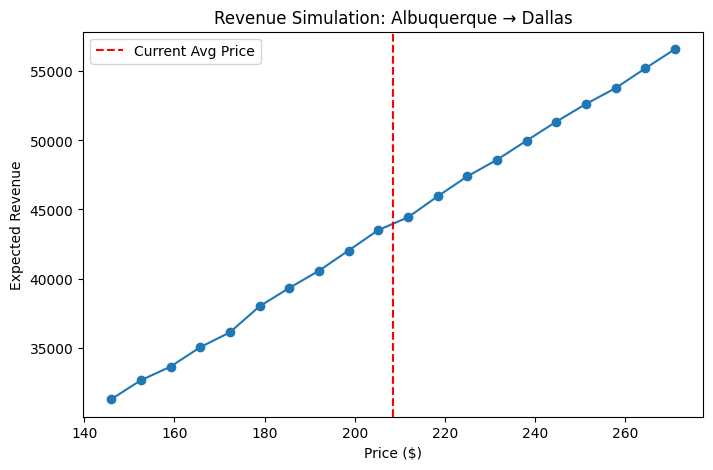

Optimal Simulated Price: 271.0591


In [24]:
# ==============================
# Step 2: Revenue Simulation
# ==============================

import numpy as np
import matplotlib.pyplot as plt

# Pick a subset (e.g., one route in 2019–2020 for clarity)
route_df = test_df[
    (test_df['city1'] == "Albuquerque, NM") &
    (test_df['city2'] == "Dallas/Fort Worth, TX")
].copy()

# Features must include 'fare'
X_route = route_df[feature_cols + ['fare']]

# Define price range (±30% around observed average)
avg_price = route_df['fare'].mean()
price_range = np.linspace(avg_price*0.7, avg_price*1.3, 20)

# Predict demand & revenue
revenues = []
for p in price_range:
    X_test = X_route.copy()
    X_test['fare'] = p
    demand_pred = demand_model.predict(X_test).mean()   # demand model trained on passengers
    revenue = p * demand_pred
    revenues.append(revenue)

# Plot revenue curve
plt.figure(figsize=(8,5))
plt.plot(price_range, revenues, marker="o")
plt.axvline(avg_price, color="red", linestyle="--", label="Current Avg Price")
plt.title("Revenue Simulation: Albuquerque → Dallas")
plt.xlabel("Price ($)")
plt.ylabel("Expected Revenue")
plt.legend()
plt.show()

best_price = price_range[np.argmax(revenues)]
print("Optimal Simulated Price:", best_price)


                                               route   avg_price  best_price  \
0  Los Angeles, CA (Metropolitan Area) → San Fran...  125.596667  163.275667   
1  Miami, FL (Metropolitan Area) → New York City,...  199.903276  259.874259   
2  Los Angeles, CA (Metropolitan Area) → New York...  313.540310  407.602403   
3  New York City, NY (Metropolitan Area) → Orland...  173.029000  224.937700   
4  Chicago, IL → New York City, NY (Metropolitan ...  200.553036  260.718946   

   current_revenue  optimal_revenue   uplift_%  
0    135490.777124    176003.774224  29.900926  
1    217766.483251    270530.086635  24.229442  
2     93231.787225    120638.270329  29.396072  
3    237777.795140    303043.527091  27.448203  
4    151800.237894    190224.101466  25.312123  


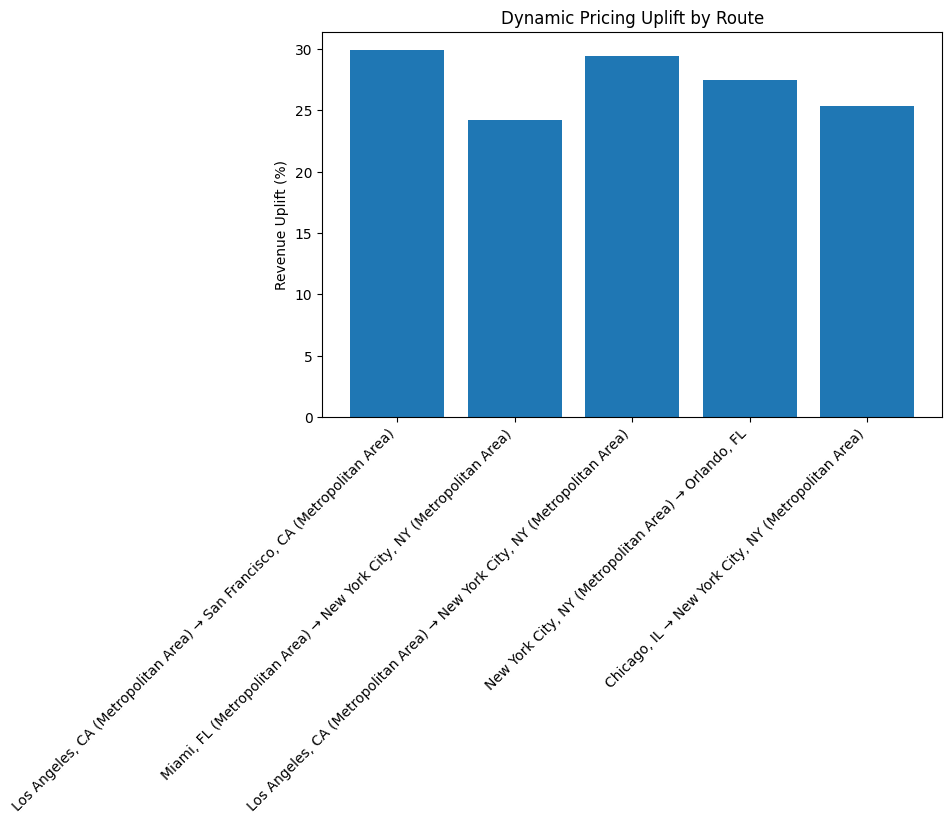

In [25]:
# ==============================
# Step 4: Multi-Route Simulation
# ==============================

def simulate_route_revenue(route_df, demand_model, feature_cols, n_prices=20):
    """
    Simulate revenue curve and optimal price for one route.
    """
    if route_df.empty:
        return None
    
    # Features must include 'fare'
    X_route = route_df[feature_cols + ['fare']]
    
    # Define price range (±30% around observed average)
    avg_price = route_df['fare'].mean()
    price_range = np.linspace(avg_price*0.7, avg_price*1.3, n_prices)
    
    revenues = []
    for p in price_range:
        X_test = X_route.copy()
        X_test['fare'] = p
        demand_pred = demand_model.predict(X_test).mean()
        revenue = p * demand_pred
        revenues.append(revenue)
    
    best_price = price_range[np.argmax(revenues)]
    best_revenue = max(revenues)
    current_revenue = avg_price * demand_model.predict(X_route).mean()
    
    uplift = (best_revenue - current_revenue) / current_revenue * 100
    
    return {
        "route": f"{route_df['city1'].iloc[0]} → {route_df['city2'].iloc[0]}",
        "avg_price": avg_price,
        "best_price": best_price,
        "current_revenue": current_revenue,
        "optimal_revenue": best_revenue,
        "uplift_%": uplift
    }

# Pick top 5 busiest routes (by passengers in test set)
top_routes = (
    test_df.groupby(['city1','city2'])['passengers']
    .sum().sort_values(ascending=False).head(5).reset_index()
)

results = []
for _, row in top_routes.iterrows():
    route_df = test_df[
        (test_df['city1'] == row['city1']) &
        (test_df['city2'] == row['city2'])
    ]
    res = simulate_route_revenue(route_df, demand_model, feature_cols)
    if res:
        results.append(res)

# Convert to DataFrame for easy viewing
results_df = pd.DataFrame(results)
print(results_df)

# Optional: plot revenue uplift per route
plt.figure(figsize=(8,5))
plt.bar(results_df['route'], results_df['uplift_%'])
plt.ylabel("Revenue Uplift (%)")
plt.title("Dynamic Pricing Uplift by Route")
plt.xticks(rotation=45, ha="right")
plt.show()


In [26]:
def simulate_route_with_constraints(route_df, demand_model, feature_cols, n_prices=20, cap=0.2):
    """
    Simulate constrained dynamic pricing (±cap around avg price).
    """
    if route_df.empty:
        return None
    
    X_route = route_df[feature_cols + ['fare']]
    avg_price = route_df['fare'].mean()
    
    # Constrained price range
    price_range = np.linspace(avg_price*(1-cap), avg_price*(1+cap), n_prices)
    
    revenues = []
    for p in price_range:
        X_test = X_route.copy()
        X_test['fare'] = p
        demand_pred = demand_model.predict(X_test).mean()
        revenue = p * demand_pred
        revenues.append(revenue)
    
    best_price = price_range[np.argmax(revenues)]
    best_revenue = max(revenues)
    current_revenue = avg_price * demand_model.predict(X_route).mean()
    uplift = (best_revenue - current_revenue) / current_revenue * 100
    
    return {
        "route": f"{route_df['city1'].iloc[0]} → {route_df['city2'].iloc[0]}",
        "avg_price": avg_price,
        "best_price": best_price,
        "current_revenue": current_revenue,
        "optimal_revenue": best_revenue,
        "uplift_%": uplift
    }

# Re-run for top 5 routes with 20% cap
results_constrained = []
for _, row in top_routes.iterrows():
    route_df = test_df[
        (test_df['city1'] == row['city1']) &
        (test_df['city2'] == row['city2'])
    ]
    res = simulate_route_with_constraints(route_df, demand_model, feature_cols, cap=0.2)
    if res:
        results_constrained.append(res)

pd.DataFrame(results_constrained)


,route,avg_price,best_price,current_revenue,optimal_revenue,uplift_%
0,"Los Angeles, CA (Metropolitan Area) → San Fran...",125.596667,150.716000,135490.777124,161445.040056,19.155741
1,"Miami, FL (Metropolitan Area) → New York City,...",199.903276,239.883931,217766.483251,255045.637940,17.118867
2,"Los Angeles, CA (Metropolitan Area) → New York...",313.540310,376.248372,93231.787225,111813.086586,19.930219
3,"New York City, NY (Metropolitan Area) → Orland...",173.029000,207.634800,237777.795140,280032.076797,17.770491
4,"Chicago, IL → New York City, NY (Metropolitan ...",200.553036,240.663643,151800.237894,176852.773749,16.503621


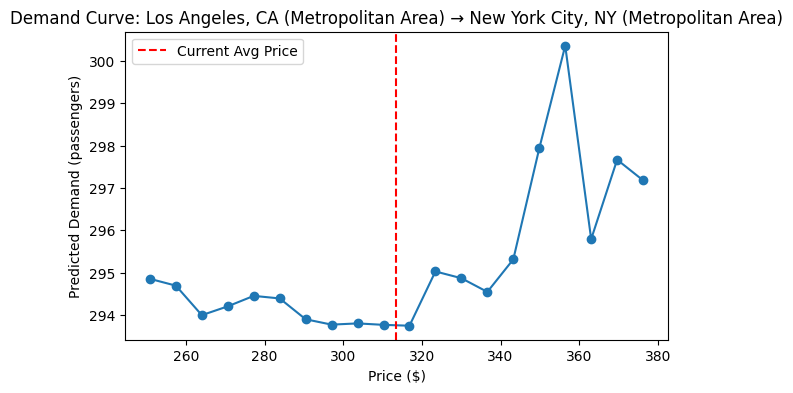

In [27]:
def plot_elasticity(route_df, demand_model, feature_cols, cap=0.2, n_prices=20):
    avg_price = route_df['fare'].mean()
    price_range = np.linspace(avg_price*(1-cap), avg_price*(1+cap), n_prices)
    
    X_route = route_df[feature_cols + ['fare']]
    demands = []
    
    for p in price_range:
        X_test = X_route.copy()
        X_test['fare'] = p
        demands.append(demand_model.predict(X_test).mean())
    
    plt.figure(figsize=(7,4))
    plt.plot(price_range, demands, marker="o")
    plt.axvline(avg_price, color="red", linestyle="--", label="Current Avg Price")
    plt.title(f"Demand Curve: {route_df['city1'].iloc[0]} → {route_df['city2'].iloc[0]}")
    plt.xlabel("Price ($)")
    plt.ylabel("Predicted Demand (passengers)")
    plt.legend()
    plt.show()

# Example: plot elasticity for Los Angeles → New York
route_df = test_df[
    (test_df['city1'] == "Los Angeles, CA (Metropolitan Area)") &
    (test_df['city2'] == "New York City, NY (Metropolitan Area)")
]
plot_elasticity(route_df, demand_model, feature_cols)


In [28]:
def pricing_policy(route_df, demand_model, feature_cols, cap=0.2):
    res = simulate_route_with_constraints(route_df, demand_model, feature_cols, cap=cap)
    if res is None:
        return None
    
    # Apply business rules
    rec_price = res["best_price"]
    
    # Round to nearest $5 for simplicity
    rec_price = round(rec_price / 5) * 5
    
    # Don’t allow >30% uplift (customer trust)
    if res["uplift_%"] > 30:
        rec_price = res["avg_price"] * 1.3
    
    res["recommended_price"] = rec_price
    return res

# Example: Apply policy for Los Angeles → New York
policy_res = pricing_policy(route_df, demand_model, feature_cols)
print(policy_res)


{'route': 'Los Angeles, CA (Metropolitan Area) → New York City, NY (Metropolitan Area)', 'avg_price': np.float64(313.54031007751934), 'best_price': np.float64(376.2483720930232), 'current_revenue': np.float64(93231.78722470305), 'optimal_revenue': np.float64(111813.08658626111), 'uplift_%': np.float64(19.930218989339178), 'recommended_price': 375}


In [29]:
import joblib

# Save trained demand model
joblib.dump(demand_model, "demand_model.pkl")

# Save feature list
joblib.dump(feature_cols, "feature_cols.pkl")

print("✅ Model and features saved to disk!")


✅ Model and features saved to disk!
